In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas


In [16]:
def DaskProfReader(filename):
    filename = open(filename,'r')
    timestamps=list()
    for line in filename:
        for item in line.split():
            if item.startswith('start_time'):
                timestamp1=float(item.split('=')[1].split(',')[0])
            elif item.startswith('end_time'):
                timestamp2=float(item.split('=')[1].split(',')[0])
        timestamps.append([timestamp1,timestamp2])
    
    filename.close()
    
    return np.array(timestamps)

def SchedulerDelay(profiles):
    delays = np.array([])
    for profile in profiles:
        start_times = profile[:,0]
        start_times.sort()
        start_times = start_times-start_times[0]
        delays = np.append(delays,start_times[0:-1])
        
    return delays

def SchedulerDelayDist(profiles):
    delays = np.array([])
    
    for profile in profiles:
        start_times = profile[1][:,0]
        start_times.sort()
        start_times=start_times-start_times[0]
        delays = np.append(delays,start_times)
    
    return delays

def TaskPerSecHist(array):
    exps = array.shape[0]
    temp = list()
    maxlen=0
    for i in range(0,exps):
        c =[0]
        sec =1
        for j in range(1,array.shape[1]):
            if array[i,j-1]<sec:
                c[sec-1]+=1
            else:
                sec+=1
                c.append(1)
        if len(c)> maxlen:
            maxlen=len(c)
        temp.append(c)
        
    hists = np.zeros((exps,maxlen))
    for i in range(0,exps):
        hists[i,0:len(temp[i])]=temp[i]
    
    return hists


In [17]:
# Dask Distributed
profiles_dist_16=list()
profiles_dist_32=list()
profiles_dist_48=list()
profiles_dist_64=list()
for i in range(0,10):
    profiles_dist_16.append(np.load('Stampede/Throughput/timingsT_16c_%02d.npz.npy'%(i+1)))
    profiles_dist_32.append(np.load('Stampede/Throughput/timingsT_32c_%02d.npz.npy'%(i+1)))
    profiles_dist_48.append(np.load('Stampede/Throughput/timingsT_48c_%02d.npz.npy'%(i+1)))
    profiles_dist_64.append(np.load('Stampede/Throughput/timingsT_64c_%02d.npz.npy'%(i+1)))

# Dask Distributed
profiles_dist_16_1t=list()
profiles_dist_32_1t=list()
profiles_dist_48_1t=list()
profiles_dist_64_1t=list()
for i in range(0,10):
    profiles_dist_16_1t.append(np.load('Stampede/Throughput/timingsT_16c_1t_%02d.npz.npy'%(i+1)))
    profiles_dist_32_1t.append(np.load('Stampede/Throughput/timingsT_32c_1t_%02d.npz.npy'%(i+1)))
    profiles_dist_48_1t.append(np.load('Stampede/Throughput/timingsT_48c_1t_%02d.npz.npy'%(i+1)))
    profiles_dist_64_1t.append(np.load('Stampede/Throughput/timingsT_64c_1t_%02d.npz.npy'%(i+1)))

# Dask Multiprocessing
profiles_multi=list()

for i in range(0,8):
    profiles_multi.append(DaskProfReader('Stampede/Throughput/multiprocT_prof%02d'%i))

# Dask Threading
profiles_thread=list()

for i in range(0,8):
    profiles_thread.append(DaskProfReader('Stampede/Throughput/threadedT_prof%d'%i))

In [18]:
threadedDelay = SchedulerDelay(profiles_thread)

multiprocDelay = SchedulerDelay(profiles_multi)

distDelay_16 = SchedulerDelayDist(profiles_dist_16)
distDelay_32 = SchedulerDelayDist(profiles_dist_32)
distDelay_48 = SchedulerDelayDist(profiles_dist_48)
distDelay_64 = SchedulerDelayDist(profiles_dist_64)

distDelay_16_1t = SchedulerDelayDist(profiles_dist_16_1t)
distDelay_32_1t = SchedulerDelayDist(profiles_dist_32_1t)
distDelay_48_1t = SchedulerDelayDist(profiles_dist_48_1t)
distDelay_64_1t = SchedulerDelayDist(profiles_dist_64_1t)

multiprocDelay = multiprocDelay.reshape(8,100000)
threadedDelay = threadedDelay.reshape(8,100000)
distDelay_16 = distDelay_16.reshape(10,100000)
distDelay_32 = distDelay_32.reshape(10,100000)
distDelay_48 = distDelay_48.reshape(10,100000)
distDelay_64 = distDelay_64.reshape(10,100000)
distDelay_16_1t = distDelay_16_1t.reshape(10,100000)
distDelay_32_1t = distDelay_32_1t.reshape(10,100000)
distDelay_48_1t = distDelay_48_1t.reshape(10,100000)
distDelay_64_1t = distDelay_64_1t.reshape(10,100000)

multiprocDelay_hist = TaskPerSecHist(multiprocDelay)
threadedDelay_hist = TaskPerSecHist(threadedDelay)
distDelay_16_hist = TaskPerSecHist(distDelay_16)
distDelay_32_hist = TaskPerSecHist(distDelay_32)
distDelay_48_hist = TaskPerSecHist(distDelay_48)
distDelay_64_hist = TaskPerSecHist(distDelay_64)
distDelay_16_1t_hist = TaskPerSecHist(distDelay_16_1t)
distDelay_32_1t_hist = TaskPerSecHist(distDelay_32_1t)
distDelay_48_1t_hist = TaskPerSecHist(distDelay_48_1t)
distDelay_64_1t_hist = TaskPerSecHist(distDelay_64_1t)

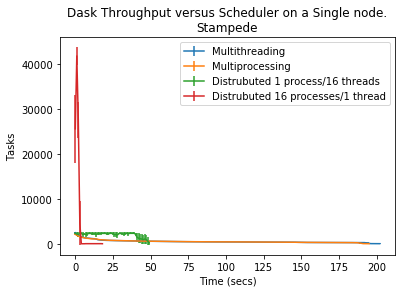

In [23]:
plt.figure()
plt.errorbar(range(0,threadedDelay_hist.shape[1]),threadedDelay_hist.mean(0),yerr=threadedDelay_hist.std(0),label='Multithreading')
plt.errorbar(range(0,multiprocDelay_hist.shape[1]),multiprocDelay_hist.mean(0),yerr=multiprocDelay_hist.std(0),label='Multiprocessing')
plt.errorbar(range(0,distDelay_16_hist.shape[1]),distDelay_16_hist.mean(0),yerr=distDelay_16_hist.std(0),label='Distrubuted 1 process/16 threads')
plt.errorbar(range(0,distDelay_16_1t_hist.shape[1]),distDelay_16_1t_hist.mean(0),yerr=distDelay_16_1t_hist.std(0),label='Distrubuted 16 processes/1 thread')
plt.legend()
plt.title('Dask Throughput versus Scheduler on a Single node.\nStampede')
plt.ylabel('Tasks')
plt.xlabel('Time (secs)')
plt.savefig('daskThroughputvsScheduler.pdf',dpi=800,bbox_inches='tight')

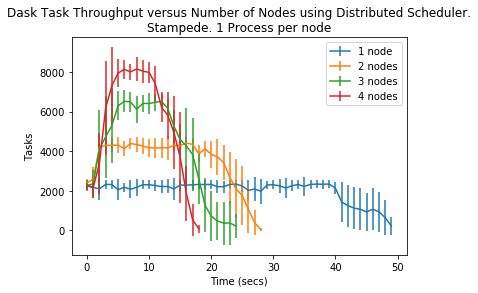

In [24]:
plt.figure()
plt.errorbar(range(0,distDelay_16_hist.shape[1]),distDelay_16_hist.mean(0),yerr=distDelay_16_hist.std(0),label='1 node')
plt.errorbar(range(0,distDelay_32_hist.shape[1]),distDelay_32_hist.mean(0),yerr=distDelay_32_hist.std(0),label='2 nodes')
plt.errorbar(range(0,distDelay_48_hist.shape[1]),distDelay_48_hist.mean(0),yerr=distDelay_48_hist.std(0),label='3 nodes')
plt.errorbar(range(0,distDelay_64_hist.shape[1]),distDelay_64_hist.mean(0),yerr=distDelay_64_hist.std(0),label='4 nodes')
plt.legend()
plt.title('Dask Task Throughput versus Number of Nodes using Distributed Scheduler.\nStampede. 1 Process per node')
plt.ylabel('Tasks')
plt.xlabel('Time (secs)')
plt.savefig('daskThroughputvsNodes.pdf',dpi=800,bbox_inches='tight')

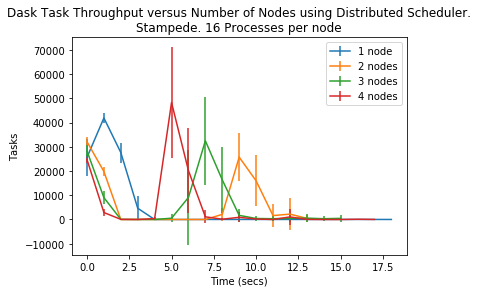

In [25]:
plt.figure()
plt.errorbar(range(0,distDelay_16_1t_hist.shape[1]),distDelay_16_1t_hist.mean(0),yerr=distDelay_16_1t_hist.std(0),label='1 node')
plt.errorbar(range(0,distDelay_32_1t_hist.shape[1]),distDelay_32_1t_hist.mean(0),yerr=distDelay_32_1t_hist.std(0),label='2 nodes')
plt.errorbar(range(0,distDelay_48_1t_hist.shape[1]),distDelay_48_1t_hist.mean(0),yerr=distDelay_48_1t_hist.std(0),label='3 nodes')
plt.errorbar(range(0,distDelay_64_1t_hist.shape[1]),distDelay_64_1t_hist.mean(0),yerr=distDelay_64_1t_hist.std(0),label='4 nodes')
plt.legend()
plt.title('Dask Task Throughput versus Number of Nodes using Distributed Scheduler.\nStampede. 16 Processes per node')
plt.ylabel('Tasks')
plt.xlabel('Time (secs)')
plt.savefig('daskThroughputvsNodes16proc.pdf',dpi=800,bbox_inches='tight')